<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNet, ElasticNetCV, SGDRegressor, SGDClassifier, LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
df = pd.read_csv('./housing.csv')
house = df

# Data Cleaning & Feature Engineering

### Cleaning Plan
> * Remove Features with Null values more than 70%
* Combine Features to get more dense data while still keeping their granular nature
* Impute Features with median or mode 
* Replacing Null Values with Feature specific values
* Substituting Ordinal Features with numerical equivalents
* Dealing with features that are time specific

** Key here is to decrease number of features while increasing overall feature relevancy & completeness **

In [4]:
# Make column headers small caps
cols = [x.lower() for x in house.columns]
house.columns = cols

In [5]:
# Check for null values:
house.isnull().sum().sort_values(ascending=False)

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
lotfrontage       259
garagecond         81
garagetype         81
garageyrblt        81
garagefinish       81
garagequal         81
bsmtexposure       38
bsmtfintype2       38
bsmtfintype1       37
bsmtcond           37
bsmtqual           37
masvnrarea          8
masvnrtype          8
electrical          1
utilities           0
yearremodadd        0
mssubclass          0
foundation          0
extercond           0
exterqual           0
exterior2nd         0
exterior1st         0
roofmatl            0
roofstyle           0
yearbuilt           0
                 ... 
garagearea          0
paveddrive          0
wooddecksf          0
openporchsf         0
3ssnporch           0
bsmtunfsf           0
screenporch         0
poolarea            0
miscval             0
mosold              0
yrsold              0
saletype            0
functional          0
totrmsabvgrd        0
kitchenqua

In [6]:
# Drop PoolQC, PoolArea, MiscFeature, Alley, Fence
house.drop(labels=['poolqc','poolarea','miscfeature','miscval','alley','fence'], axis=1, inplace=True)

In [7]:
# Drop Id Column
house.drop(labels='id', axis=1, inplace=True)

In [8]:
# Dealing with Null for Fire Place Quality
house.fireplacequ.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: fireplacequ, dtype: int64

In [9]:
# Replace Null with NA means no fire place
# fill fire place quality nan with NA
house.fireplacequ.fillna('NA', inplace=True)

In [10]:
def null_weighted_imputation(df_series):
    total_abv_0 = df_series.where(df_series > 0).value_counts().sum()
    weight_df = (df_series.where(df_series > 0).value_counts() / total_abv_0).to_frame()
    values = weight_df.index.tolist()
    weights = weight_df.values.ravel()
    df_series = df_series.fillna(np.random.choice(values, p=weights))
    return df_series

In [11]:
# Dealing with null in Lot Frontage
# Impute with weighted random selection from distribution
series = null_weighted_imputation(house.lotfrontage)
house.lotfrontage = series

In [12]:
# Dealing with null for Garage columns
house[house.garagecond.isnull()].loc[:,['garagecond','garagetype','garageyrblt','garagefinish','garagequal']]

,garagecond,garagetype,garageyrblt,garagefinish,garagequal
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN


In [13]:
# All nan values occur in same row
# Fill them with NA meaning no garage
# Garage year fill with median
house.garageyrblt.fillna(house.garageyrblt.median(), inplace=True)
house.garagetype.fillna('NA', inplace=True)
house.garagefinish.fillna('NA', inplace=True)
house.garagequal.fillna('NA', inplace=True)
house.garagecond.fillna('NA', inplace=True)

In [14]:
# Dealing with nan values in basement columns
house[house.bsmtfintype2.isnull()].loc[:,['bsmtexposure','bsmtfintype2','bsmtfintype1','bsmtcond','bsmtqual']]

,bsmtexposure,bsmtfintype2,bsmtfintype1,bsmtcond,bsmtqual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,No,NaN,GLQ,TA,Gd
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


In [15]:
# Nan values all in same row
# There is 1 nan in bsmt exposure & bsmtfintype2 that must be replaced by mode
print house.bsmtexposure.value_counts().sort_values(ascending=False)
print house.bsmtfintype2.value_counts().sort_values(ascending=False)

No    953
Av    221
Gd    134
Mn    114
Name: bsmtexposure, dtype: int64
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: bsmtfintype2, dtype: int64


In [16]:
house.loc[948,'bsmtexposure'] = 'No'
house.loc[332,'bsmtfintype2'] = 'Unf'

In [17]:
# The rest can be replaced with none meaning no basement
house.bsmtexposure.fillna('NA', inplace=True)
house.bsmtfintype2.fillna('NA', inplace=True)
house.bsmtfintype1.fillna('NA', inplace=True)
house.bsmtcond.fillna('NA', inplace=True)
house.bsmtqual.fillna('NA', inplace=True)

In [18]:
# fill MasVnrType nan with 'None' & MasVnrArea nan with 0
house[house.masvnrtype.isnull()].loc[:,['masvnrtype','masvnrarea']]

,masvnrtype,masvnrarea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [19]:
house.masvnrtype.fillna('None', inplace=True)
house.masvnrarea.fillna(0, inplace=True)

In [20]:
# replace nan for electrical with mode
house.electrical.value_counts().sort_values(ascending=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64

In [21]:
house.electrical.fillna('SBrkr', inplace=True)

In [22]:
# All columns have no null

In [23]:
# Now lets do some feature engineering
# Setting dtypes, Combinations, time and ordinal columns

In [24]:
# drop mssubclass, its a combination of year built,bldgtype, housestyle
house.drop(labels='mssubclass', axis=1, inplace=True)

In [25]:
# condition 1 & 2 can be combined
house['condition'] = house.condition1 + house.condition2
house.drop(labels=['condition1','condition2'], axis=1, inplace=True)
# exterior1st and exterior2nd can be combined
house['exterior'] = house.exterior1st + house.exterior2nd
house.drop(labels=['exterior1st','exterior2nd'], axis=1, inplace=True)
# combine bsmtfinsf1 / 2 then divide by totalbsmtsf to get percent done
house['bsmtfinsf'] = house.bsmtfinsf1 + house.bsmtfinsf2
house.drop(labels=['bsmtfinsf1','bsmtfinsf2'], axis=1, inplace=True)
# (grlivarea - lowqualfinsf) / grlivarea to get percent high quality
house['highqualfinsf_perc'] = (house.grlivarea - house.lowqualfinsf) / house.grlivarea
house.drop(labels=['1stflrsf','2ndflrsf','lowqualfinsf'], axis=1, inplace=True)
# add total rooms above ground & bath rooms above ground & basement to get total rooms in house
# without basement bedrooms
house['totrms_without_bsmtbedrm'] = house.totrmsabvgrd + house.fullbath + house.halfbath + house.bsmtfullbath + house.bsmthalfbath
house.drop(labels=['totrmsabvgrd','fullbath','halfbath','bsmtfullbath','bsmthalfbath','bedroomabvgr','kitchenabvgr'], axis=1, inplace=True)
# combine deck and porch square feet
house['totdeckporchsf'] = house.wooddecksf + house.openporchsf + house.enclosedporch + house['3ssnporch'] + house.screenporch
house.drop(labels=['wooddecksf','openporchsf','enclosedporch','3ssnporch','screenporch'], axis=1, inplace=True)

In [26]:
# transform ordinal features into their numerical equivalents
# the quality / condition columns
house.exterqual = house.exterqual.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' 
                                      else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.extercond = house.extercond.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' else 3 if x == 'TA' 
                                      else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.bsmtqual = house.bsmtqual.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.bsmtcond = house.bsmtcond.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.bsmtexposure = house.bsmtexposure.map(lambda x: 4 if x == 'Gd' else 3 if x == 'Av' else 2 if x == 'Mn' 
                                            else 1 if x == 'No' else x)
house.bsmtfintype1 = house.bsmtfintype1.map(lambda x: 6 if x == 'GLQ' else 5 if x == 'ALQ' else 4 if x == 'BLQ' 
                                      else 3 if x == 'Rec' else 2 if x == 'LwQ' else 1 if x == 'Unf' else x)
house.bsmtfintype2 = house.bsmtfintype2.map(lambda x: 6 if x == 'GLQ' else 5 if x == 'ALQ' else 4 if x == 'BLQ' 
                                      else 3 if x == 'Rec' else 2 if x == 'LwQ' else 1 if x == 'Unf' else x)
house.heatingqc = house.heatingqc.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.kitchenqual = house.kitchenqual.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.fireplacequ = house.fireplacequ.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.garagequal = house.garagequal.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)
house.garagecond = house.garagecond.map(lambda x: 5 if x == 'Ex' else 4 if x == 'Gd' 
                                      else 3 if x == 'TA' else 2 if x == 'Fa' else 1 if x == 'Po' else x)

In [27]:
# Transform year columns into age
house['age'] = house.yrsold - house.yearbuilt
house['age_remodel'] = house.yrsold - house.yearremodadd
house.drop(labels=['yearbuilt','yearremodadd'], axis=1, inplace=True)
house['garageage'] = house.yrsold - house.garageyrblt
house.drop(labels='garageyrblt', axis=1, inplace=True)
# Transform mosold into a circular dataset but dont know how
# Month 12 and month 1 are very close not very far...
# Alternative is to create dummies for each month which is what i will do
house.mosold = house.mosold.astype('object')
house.yrsold = house.yrsold.astype('object')

In [28]:
# Add fintype 1 and fintype 2 
house['bsmtfintype'] = house.bsmtfintype1 + house.bsmtfintype2
house.drop(labels=['bsmtfintype1','bsmtfintype2'], axis=1, inplace=True)

In [29]:
# only want residential
house.mszoning.unique()
house = house[house.mszoning != 'C (all)']

In [30]:
house.reset_index(drop=True, inplace=True)
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 57 columns):
mszoning                    1450 non-null object
lotfrontage                 1450 non-null float64
lotarea                     1450 non-null int64
street                      1450 non-null object
lotshape                    1450 non-null object
landcontour                 1450 non-null object
utilities                   1450 non-null object
lotconfig                   1450 non-null object
landslope                   1450 non-null object
neighborhood                1450 non-null object
bldgtype                    1450 non-null object
housestyle                  1450 non-null object
overallqual                 1450 non-null int64
overallcond                 1450 non-null int64
roofstyle                   1450 non-null object
roofmatl                    1450 non-null object
masvnrtype                  1450 non-null object
masvnrarea                  1450 non-null float64
exterqual   

# Exploratory Data Analysis

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


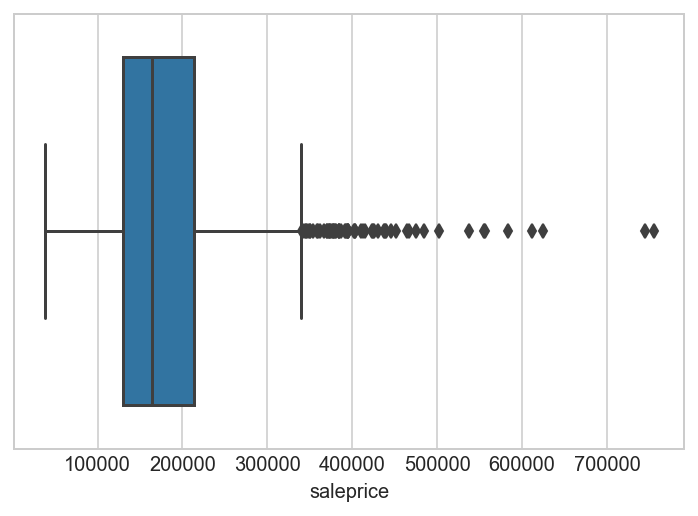

In [31]:
# Remove outliers for better prediction
sns.boxplot(house.saleprice)

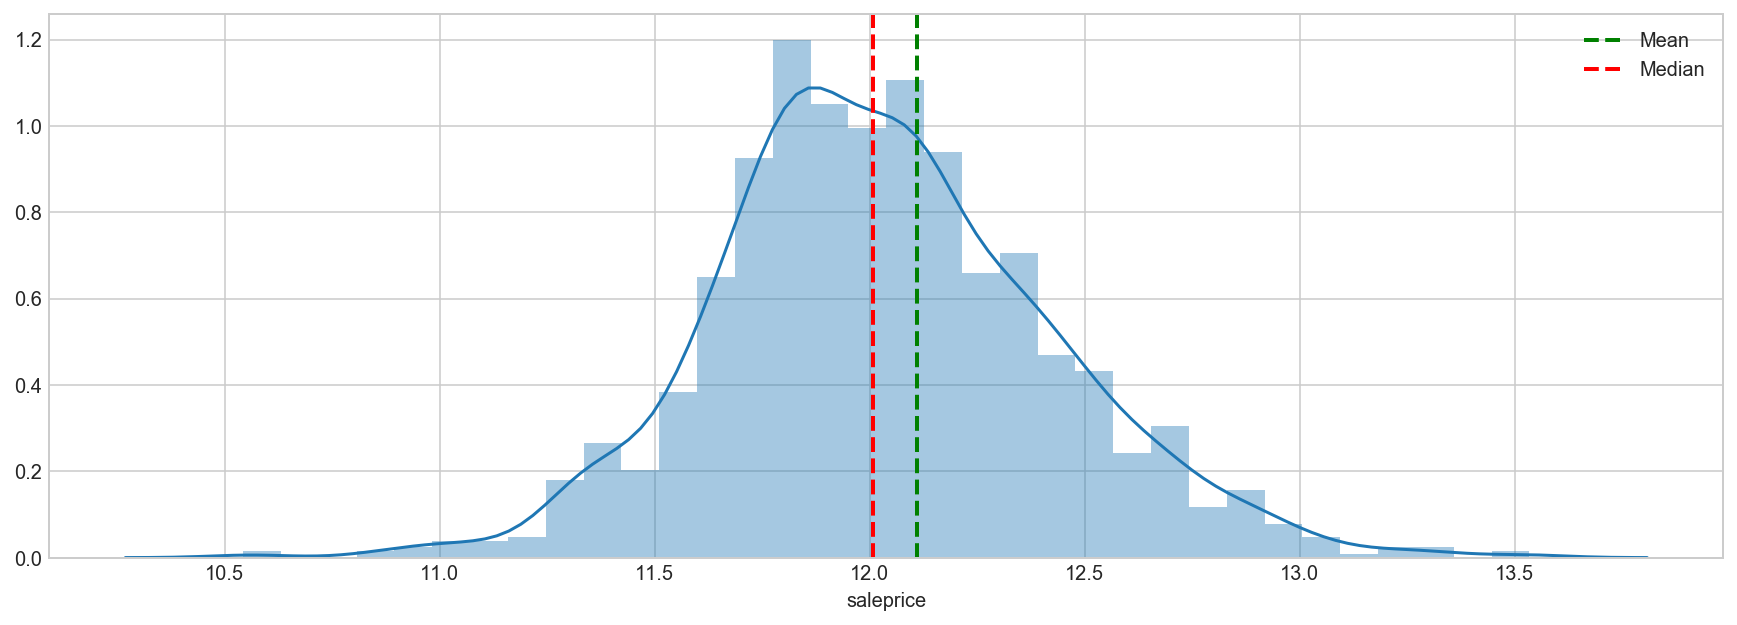

In [32]:
# Distribution has many outliers
# Transform it via log
plt.figure(figsize=(15,5))
sns.distplot(np.log(house.saleprice))
plt.axvline(np.log(house.saleprice.mean()), color='g', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(np.log(house.saleprice.median()), color='r', linestyle='dashed', linewidth=2, label='Median')
plt.legend()

In [33]:
# The logged price distribution more normally distributed than original
# We shall use the log sale price as our target
house.saleprice = np.log(house.saleprice)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


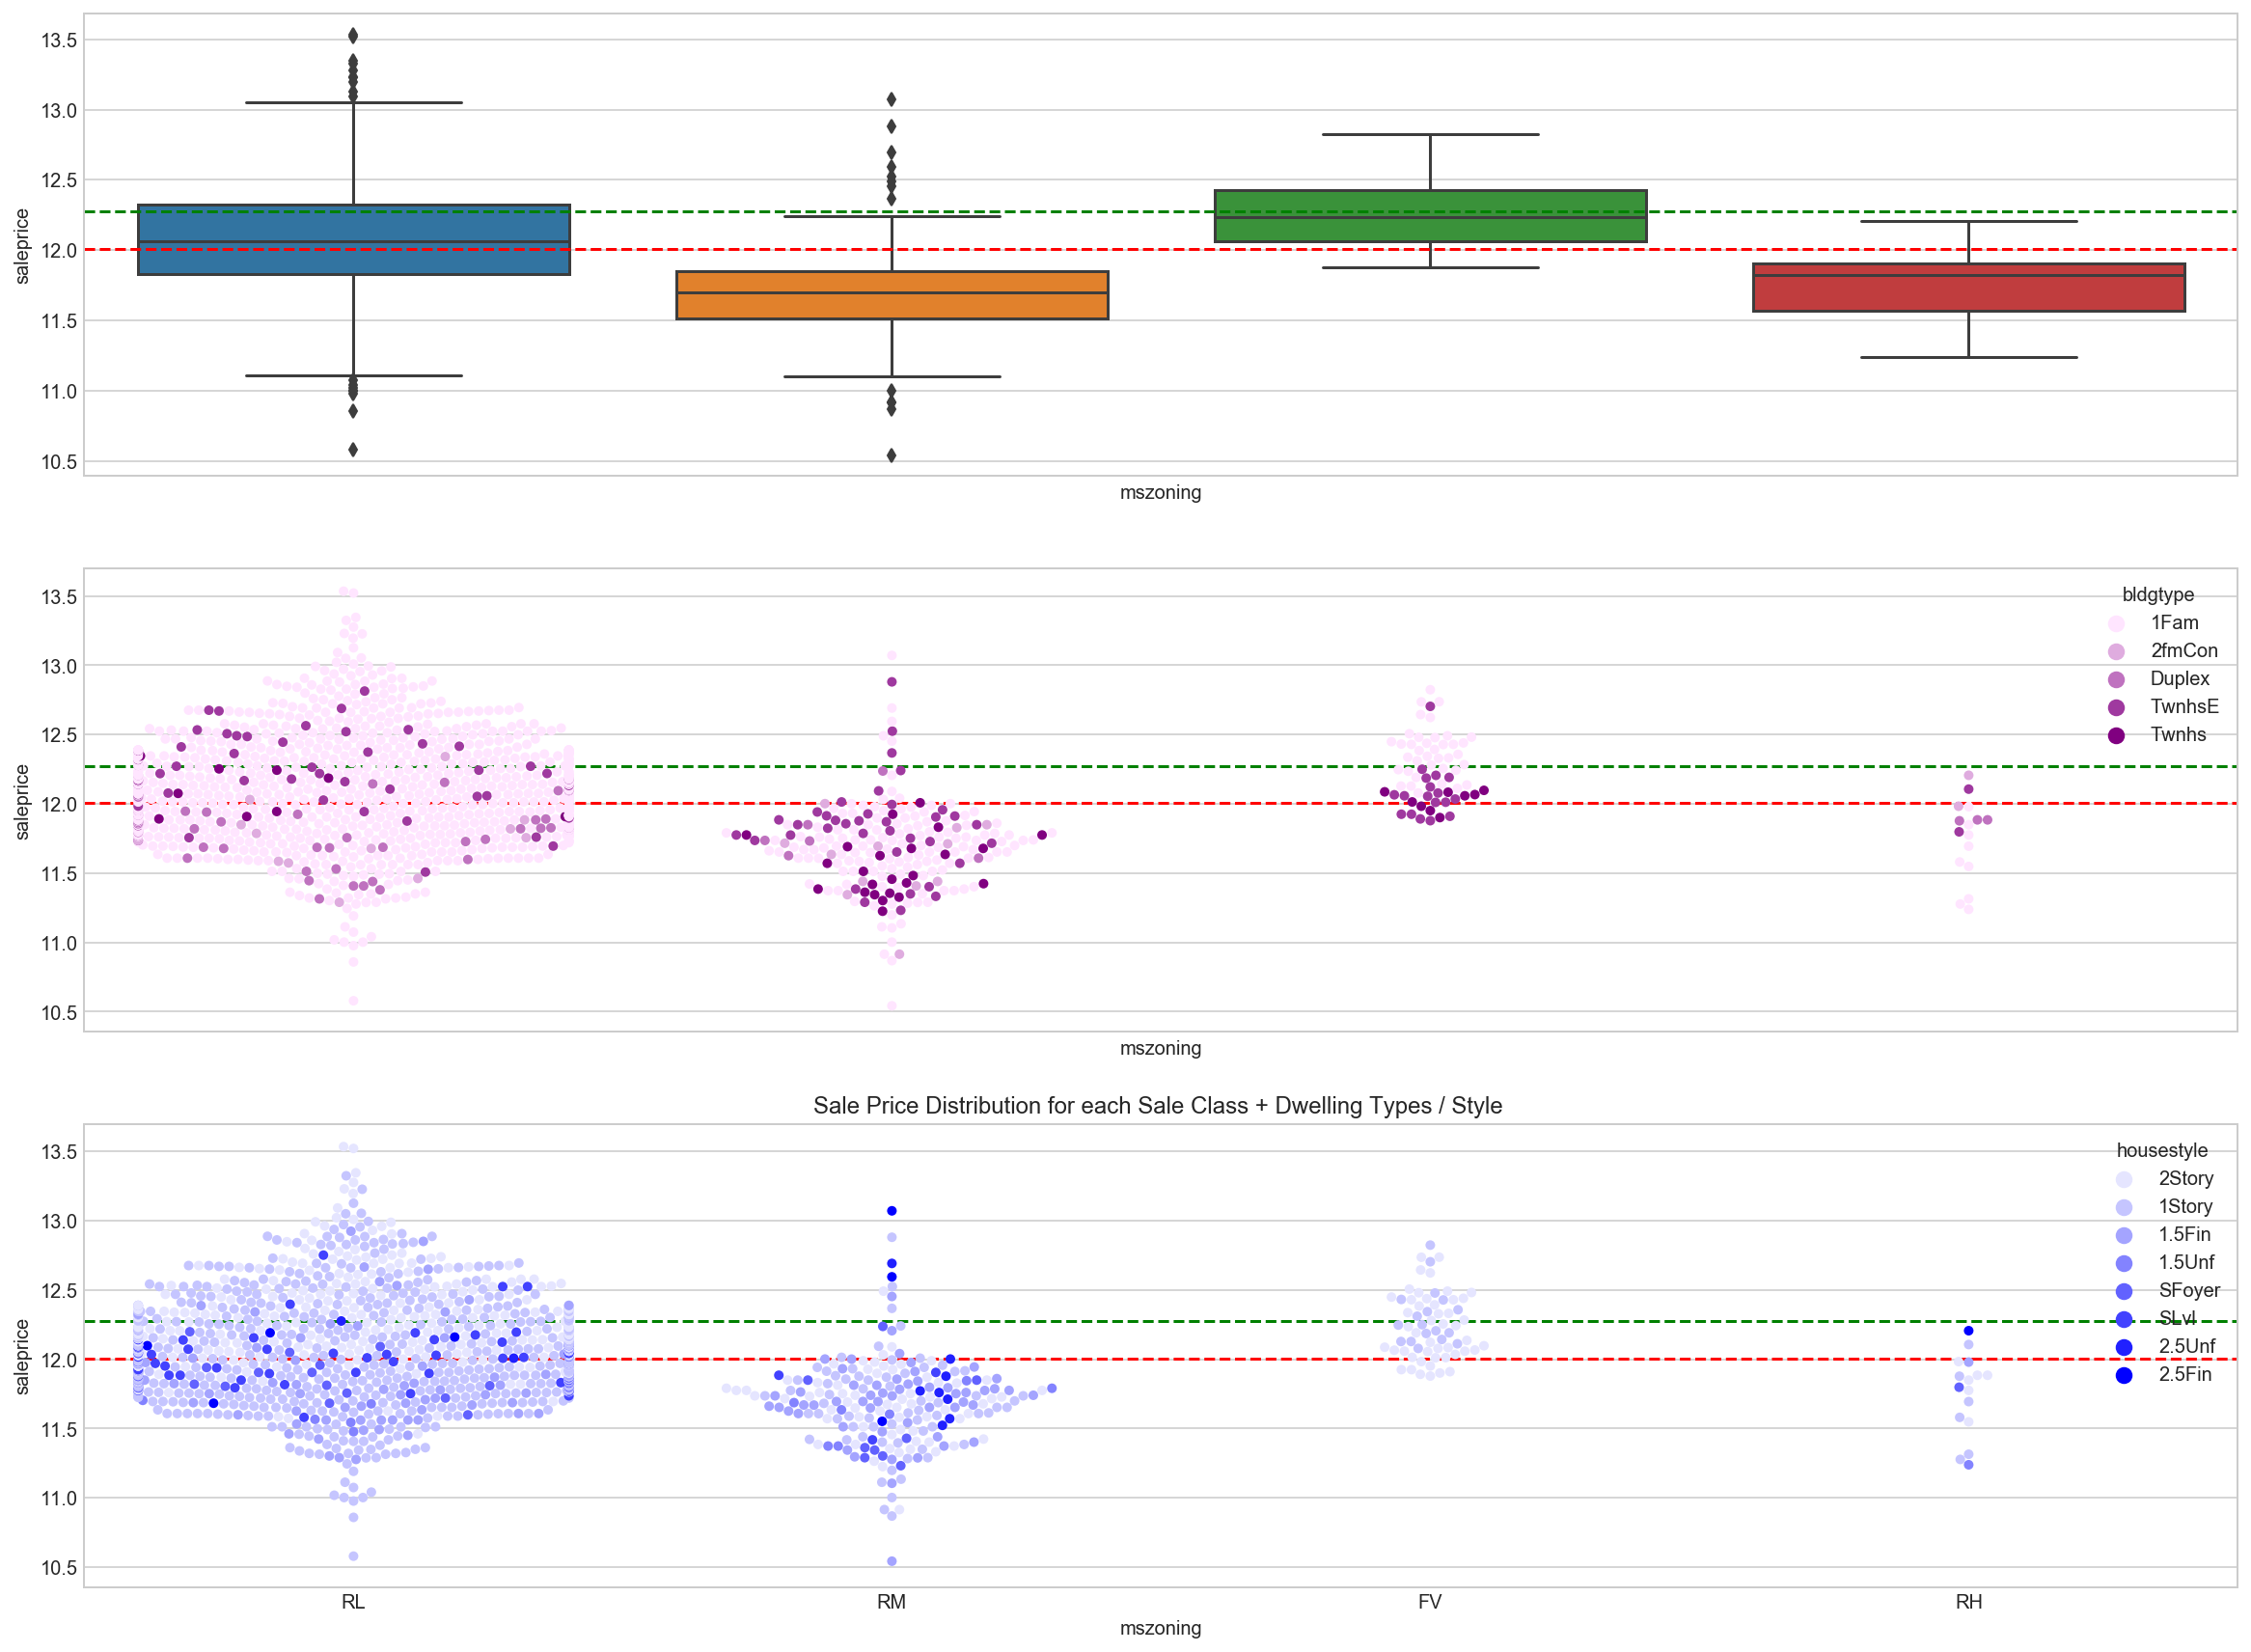

In [34]:
# Observe the Variations of Sales Price and Types and Style of Dwelling among different Zoning Classifications
fig, ax = plt.subplots(3, 1, sharex='col', sharey='row', figsize=(20,15))

palette_1 = sns.light_palette("purple", reverse=False,  n_colors=len(house.bldgtype.unique()))
palette_2 = sns.light_palette("blue", reverse=False,  n_colors=len(house.housestyle.unique()))
plt.title('Sale Price Distribution for each Sale Class + Dwelling Types / Style ')

sp_75p = house.saleprice.describe()['75%']
sp_med = house.saleprice.median()

sns.boxplot(x=house.mszoning, y=house.saleprice, ax=ax[0])
sns.swarmplot(x=house.mszoning, y=house.saleprice, hue=house.bldgtype, palette=palette_1, ax=ax[1])
sns.swarmplot(x=house.mszoning, y=house.saleprice, hue=house.housestyle, palette=palette_2, ax=ax[2])

x = plt.gca().axes.get_xlim()
ax[0].plot(x, len(x) * [sp_med], 'r--')
ax[0].plot(x, len(x) * [sp_75p], 'g--')
ax[1].plot(x, len(x) * [sp_med], 'r--')
ax[1].plot(x, len(x) * [sp_75p], 'g--')
ax[2].plot(x, len(x) * [sp_med], 'r--')
ax[2].plot(x, len(x) * [sp_75p], 'g--')

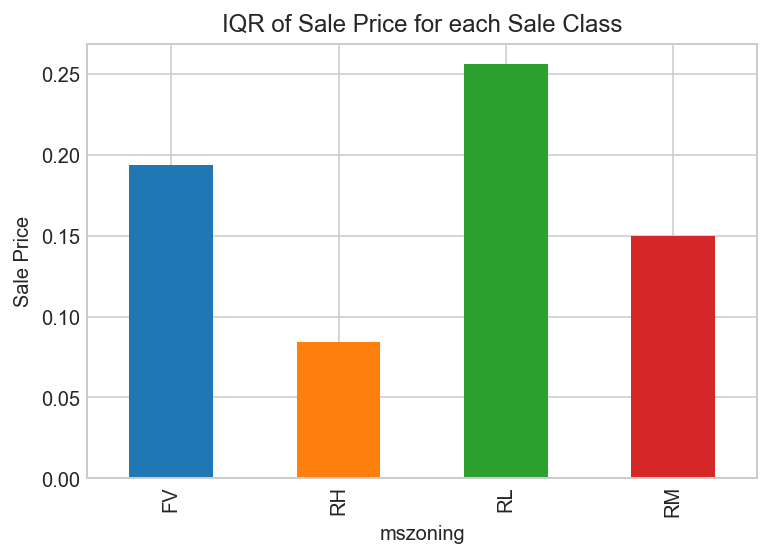

In [35]:
# Get conservative estimate of profit potential for each Classification
# Assuming we buy at expected price (median Sale Price) and sell at 75th Percentile
mszoning_stats = house.groupby('mszoning')['saleprice'].describe()
plt.title('IQR of Sale Price for each Sale Class')
plt.ylabel('Sale Price')
(mszoning_stats.loc[:,'75%'] - mszoning_stats.loc[:,'50%']).plot(kind='bar')

In [36]:
# Residential Low Density (RL) housing captures the most number of sales transactions,  
# and the largest profit potential (75th percentile - 50th percentile)
# We can hypothesize that buyers are generally more interested in RL houses
# and are more willing to pay a premium for such houses.
# RL housing market suits our short term goal very well

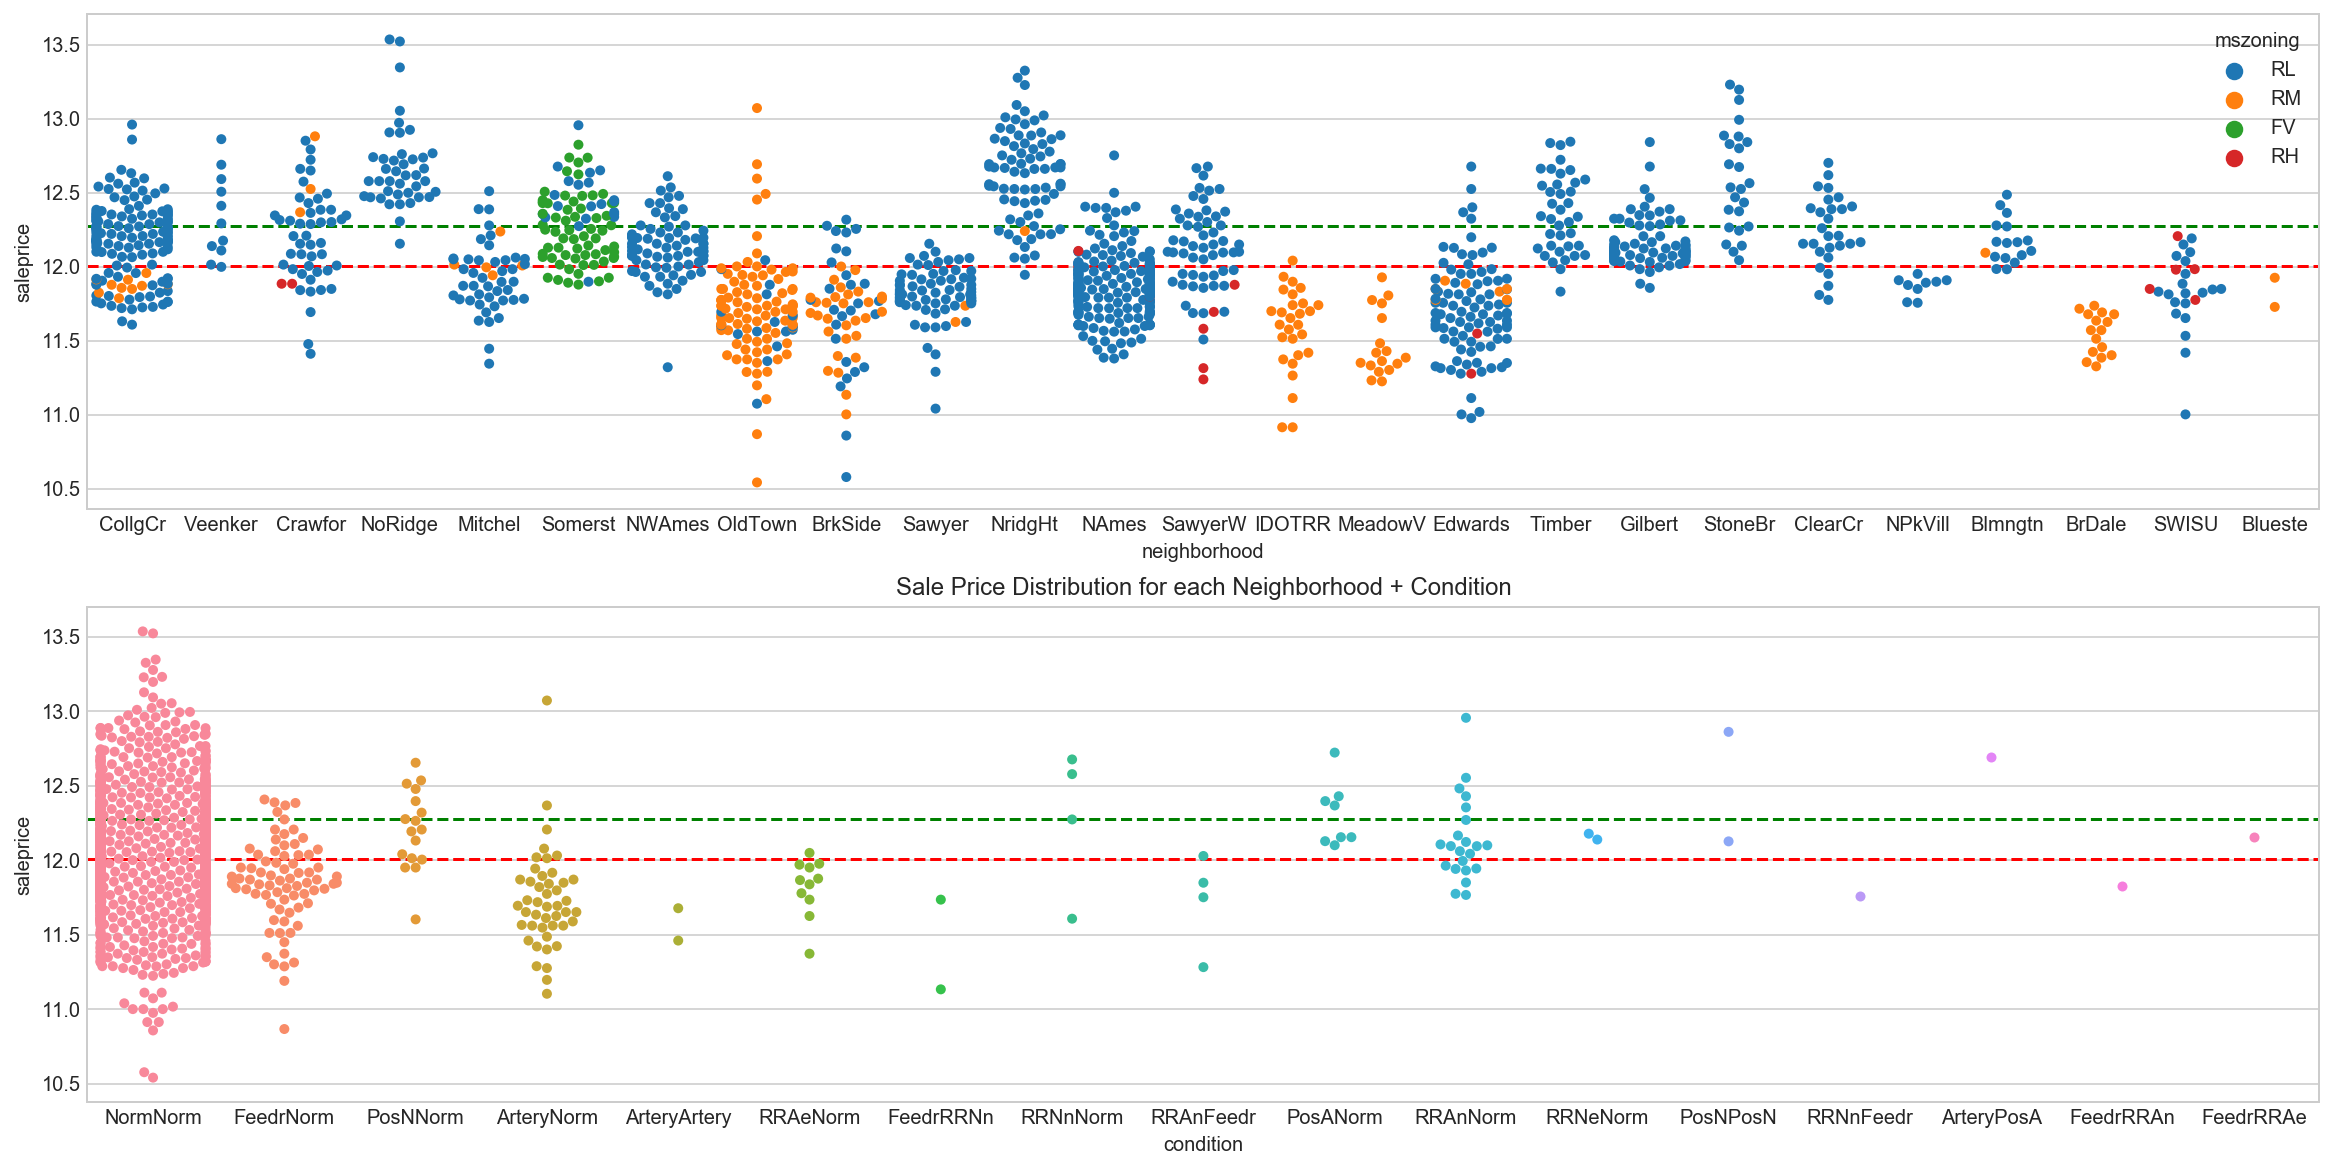

In [37]:
# They say location affects the prices of real estate
# Lets investigate location features:
# 'Neighborhood','Condition1','Condition2'
fig, ax = plt.subplots(2, 1, sharey='row', figsize=(20,10))
plt.title('Sale Price Distribution for each Neighborhood + Condition')

sns.swarmplot(x=house.neighborhood, y=house.saleprice, hue=house.mszoning, ax=ax[0])
sns.swarmplot(x=house.condition, y=house.saleprice, ax=ax[1])

x = ax[0].get_xlim()
ax[0].plot(x, len(x) * [sp_med], 'r--')
ax[0].plot(x, len(x) * [sp_75p], 'g--')
ax[1].plot(x, len(x) * [sp_med], 'r--')
ax[1].plot(x, len(x) * [sp_75p], 'g--')

In [38]:
# From the chart above, we can find out what are the sale price distribution for each neighborhood and condition

# The red and green line signifies the median and the 75th percentile Sale Price respectively
# For our short term goal we will want to identify neighborhoods with Sale Prices that lie within this range
# The higher the bulk of the distribution the lies within the range, the higher the chance of us executing our
# flipping strategy

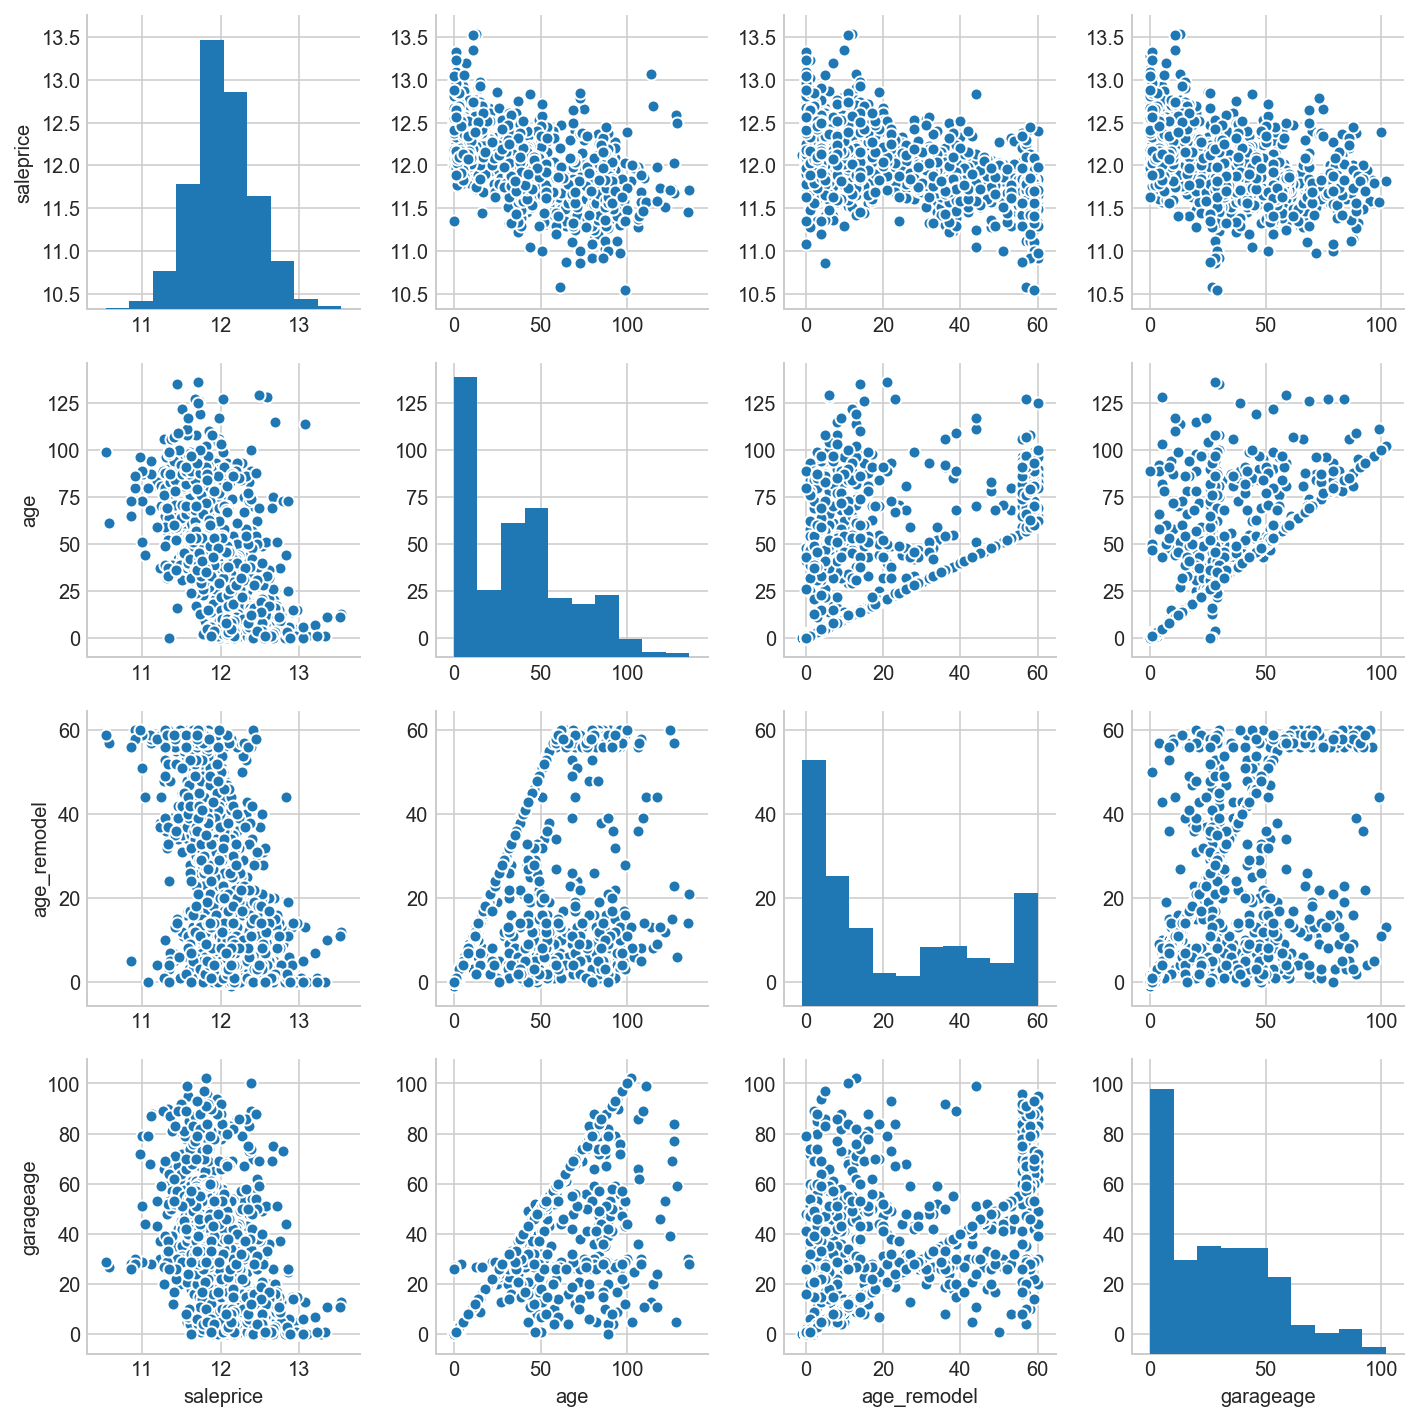

In [39]:
# plot Year columns against Sale Price
temp_df = house[['saleprice','age','age_remodel','garageage']]
sns.pairplot(temp_df)

In [40]:
# It seems like the younger the property, the higher the sale price 
# but in actual fact it might be just inflation

In [41]:
# Divide data into continuous and categorical columns
con_cols = [x for x in house.columns if house[x].dtype == 'int64' or house[x].dtype == 'float64']
cat_cols = [x for x in house.columns if x not in con_cols]

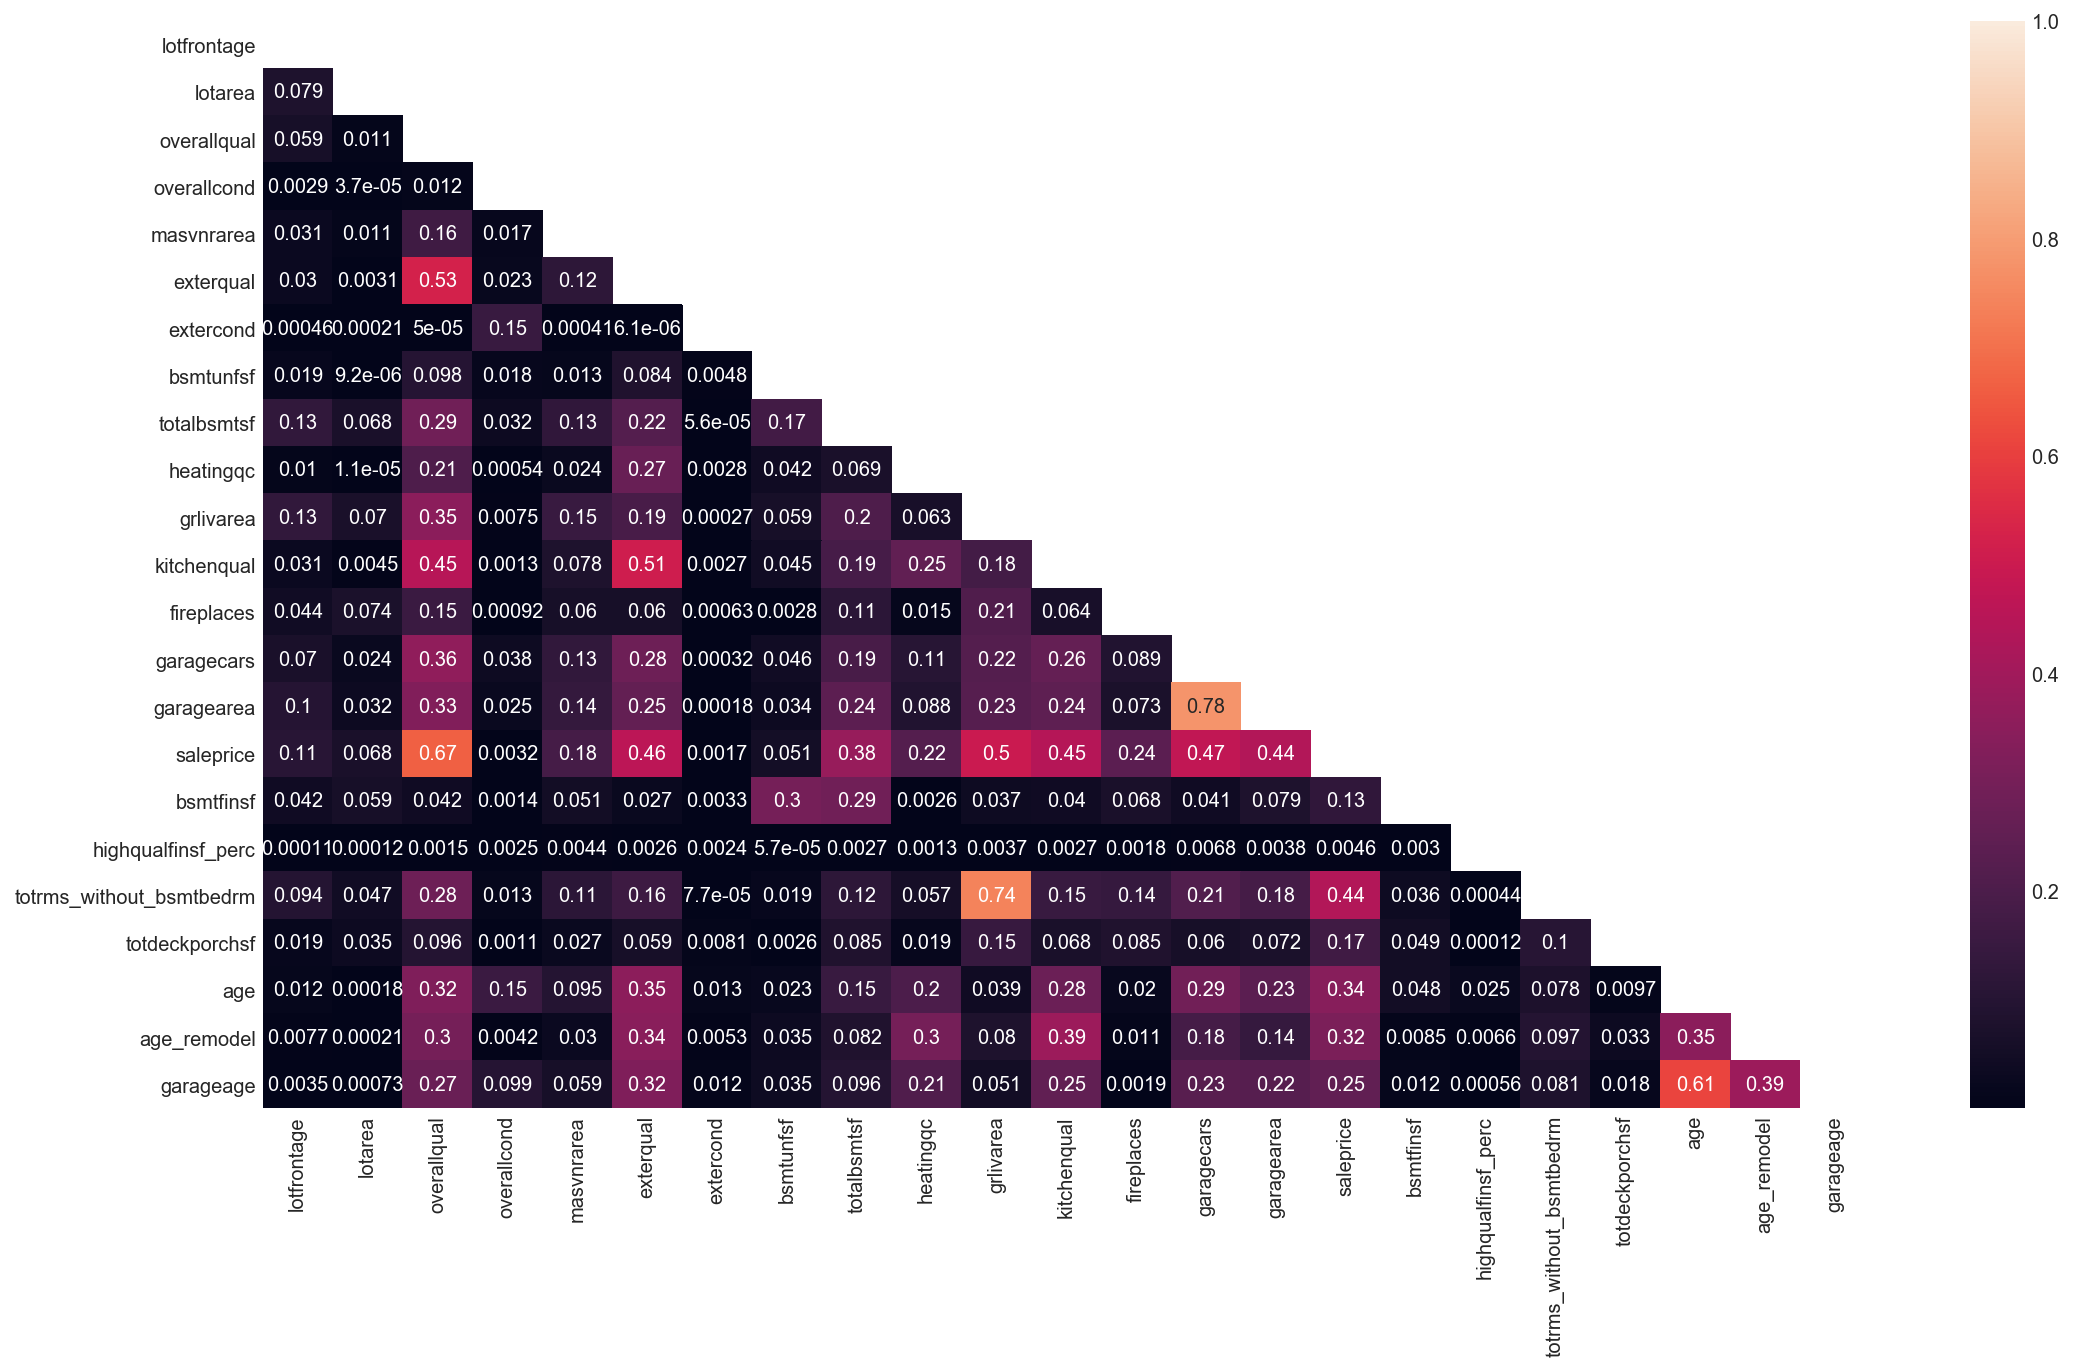

In [42]:
# Plot continuous variables + Sale Price
corr = house[con_cols].corr()**2

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, ax=ax)

In [43]:
# test significance for highly correlated values
print ss.pearsonr(house.garagecars, house.garagearea)
print ss.pearsonr(house.grlivarea, house.totrms_without_bsmtbedrm)

(0.88300909105630798, 0.0)
(0.85952538149309665, 0.0)


In [44]:
# reject null hypothesis, there is significant correlation
house.drop(labels=['garagecars','totrms_without_bsmtbedrm'], axis=1, inplace=True)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# len of categorical features
cat_cols = np.array(cat_cols)
cat_cols.shape = (17,2)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


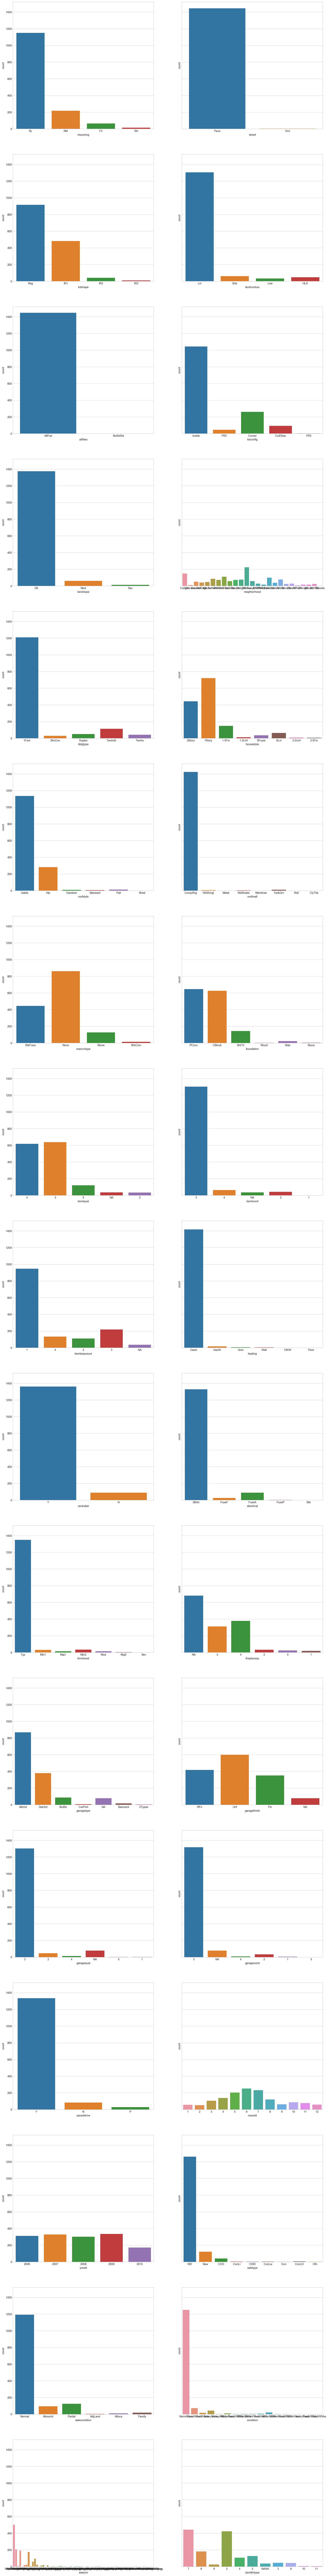

In [46]:
# Plot Categorical features against one another to observe distributions
# Shortlist those features with extremely low variance because they are unable to explain the changes in sale price
f, ax = plt.subplots(cat_cols.shape[0], cat_cols.shape[1], sharey=True, figsize=(20,cat_cols.shape[0]*10))

for r, row in enumerate(cat_cols):
    for i, col in enumerate(row):
        sns.countplot(x=house[col], ax=ax[r,i])

In [47]:
low_var = ['street','utilities','roofmatl','heating','landcontour','landslope']
# remove these low variance columns
house.drop(labels=low_var, axis=1, inplace=True) 

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Fixed Features

In [48]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 49 columns):
mszoning              1450 non-null object
lotfrontage           1450 non-null float64
lotarea               1450 non-null int64
lotshape              1450 non-null object
lotconfig             1450 non-null object
neighborhood          1450 non-null object
bldgtype              1450 non-null object
housestyle            1450 non-null object
overallqual           1450 non-null int64
overallcond           1450 non-null int64
roofstyle             1450 non-null object
masvnrtype            1450 non-null object
masvnrarea            1450 non-null float64
exterqual             1450 non-null int64
extercond             1450 non-null int64
foundation            1450 non-null object
bsmtqual              1450 non-null object
bsmtcond              1450 non-null object
bsmtexposure          1450 non-null object
bsmtunfsf             1450 non-null int64
totalbsmtsf           1450 non-null i

In [49]:
# list of fixed column labels
fixed_features = ['mszoning','lotfrontage','lotarea','lotshape','lotconfig','masvnrtype','masvnrarea','fireplaces',
                 'neighborhood','bldgtype','housestyle','foundation','totalbsmtsf','grlivarea','garagetype',
                 'garagearea', 'paveddrive','mosold','yrsold','condition','bsmtfinsf','bsmtunfsf','totdeckporchsf',
                 'highqualfinsf_perc','age','age_remodel','garageage','saleprice']
len(fixed_features)

28

# Fixed Data with Reponse Target

In [50]:
# Get fixed features from house data with Sale price
fixed_house = house[fixed_features]

In [51]:
# Get X train & y train
f = 'saleprice ~ ' + ' + '.join([col for col in fixed_house.columns if col != 'saleprice'])
print(f)
y, X = patsy.dmatrices(f, data=fixed_house, return_type='dataframe')

saleprice ~ mszoning + lotfrontage + lotarea + lotshape + lotconfig + masvnrtype + masvnrarea + fireplaces + neighborhood + bldgtype + housestyle + foundation + totalbsmtsf + grlivarea + garagetype + garagearea + paveddrive + mosold + yrsold + condition + bsmtfinsf + bsmtunfsf + totdeckporchsf + highqualfinsf_perc + age + age_remodel + garageage


In [52]:
# get train data for X
X_train = X[X['yrsold[T.2010]'] != 1]
X_test = X[X['yrsold[T.2010]'] == 1]
print X_train.shape
print X_test.shape

(1278, 107)
(172, 107)


In [53]:
# get train data for y
y_train = y.loc[X_train.index].values.ravel()
y_test = y.loc[X_test.index].values.ravel()
print y_train.shape
print y_test.shape

(1278,)
(172,)


# Optimization & Model Training

In [54]:
# Deal with multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
vif = pd.DataFrame()
vif["vif_factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [56]:
indep_var_mask = vif[vif['vif_factor']<=5].features.values.ravel()

In [57]:
Xs_train = StandardScaler().fit_transform(X_train[indep_var_mask])
Xs_test = StandardScaler().fit_transform(X_test[indep_var_mask])

In [58]:
# Compute Plain Vanilla Linear regression
linreg = LinearRegression()
linreg.fit(Xs_train, y_train)
linreg_pred = linreg.predict(Xs_test)
print'Linear Reg train R2:', linreg.score(Xs_train, y_train)
print'Linear Reg R2:', metrics.r2_score(y_test, linreg_pred)
print'Linear Reg RMSE:', np.sqrt(metrics.mean_squared_error(y_test, linreg_pred))

Linear Reg train R2: 0.762697596436
Linear Reg R2: 0.732894318713
Linear Reg RMSE: 0.203464725065


In [59]:
# Ridge
ridge_alphas = np.logspace(0, 5, 500)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print optimal_ridge.alpha_

163.843364558


In [60]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(Xs_train, y_train)
ridge_pred = ridge.predict(Xs_test)
print'Ridge train R2:', ridge.score(Xs_train, y_train)
print'Ridge R2:', metrics.r2_score(y_test, ridge_pred)
print'Ridge RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_pred))

Ridge train R2: 0.759390182851
Ridge R2: 0.73643143353
Ridge RMSE: 0.202113056767


In [61]:
# Lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs_train, y_train)

print optimal_lasso.alpha_

0.00436691784503


In [62]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(Xs_train, y_train)
lasso_pred = lasso.predict(Xs_test)
print'Lasso train R2:', lasso.score(Xs_train, y_train)
print'Lasso R2:', metrics.r2_score(y_test, lasso_pred)
print'Lasso RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_pred))

Lasso train R2: 0.756330097177
Lasso R2: 0.738718899464
Lasso RMSE: 0.201234093413


In [63]:
# Get all the Non Zero Betas
lasso_coefs = pd.DataFrame({'coef':lasso.coef_,
                            'mag':np.abs(lasso.coef_),
                            'pred':X_train[indep_var_mask].columns})

lasso_coefs.sort_values('mag', inplace=True, ascending=False)

In [64]:
lasso_nonzerobeta_features = lasso_coefs[lasso_coefs.mag != 0]

In [65]:
print 'Percent variables not zeroed out:', lasso_nonzerobeta_features.shape[0]/float(lasso_coefs.shape[0]) * 100

Percent variables not zeroed out: 68.6567164179


In [66]:
# Elastic Net
l1_ratios = np.linspace(0.01, 1.0, 99)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=500, cv=10)
optimal_enet.fit(Xs_train, y_train)
print optimal_enet.alpha_
print optimal_enet.l1_ratio_

0.0619746580797
0.0605102040816


In [67]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet.fit(Xs_train, y_train)
enet_pred = enet.predict(Xs_test)
print'ElasticNet train R2:', enet.score(Xs_train, y_train)
print'ElasticNet R2:', metrics.r2_score(y_test, enet_pred)
print'EasticNet RMSE:', np.sqrt(metrics.mean_squared_error(y_test, enet_pred))

ElasticNet train R2: 0.756101328514
ElasticNet R2: 0.737877221996
EasticNet RMSE: 0.201557955372


In [68]:
# Get all the Non Zero Betas
enet_coefs = pd.DataFrame({'coef':enet.coef_,
                            'mag':np.abs(enet.coef_),
                            'pred':X_train[indep_var_mask].columns})

enet_coefs.sort_values('mag', inplace=True, ascending=False)

In [69]:
enet_nonzerobeta_features = enet_coefs[enet_coefs.mag != 0]

In [70]:
print 'Percent variables not zeroed out:', enet_nonzerobeta_features.shape[0]/float(enet_coefs.shape[0]) * 100

Percent variables not zeroed out: 71.6417910448


In [71]:
# Gradient Descent Optimization, Penalty use Lasso & Ridge
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-10,5,500)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=10, verbose=False)

In [72]:
sgd_reg_gs.fit(Xs_train, y_train)

/Users/david.yan/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'alpha': array([  1.00000e-10,   1.07167e-10, ...,   9.33125e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [73]:
# Gradient Descent best penalty is Ridge
print sgd_reg_gs.best_params_
print sgd_reg_gs.best_score_
sgd_reg = sgd_reg_gs.best_estimator_

{'penalty': 'l2', 'alpha': 0.51217554433642409, 'loss': 'squared_loss'}
0.712439746375


In [74]:
sgd_reg.fit(Xs_train, y_train)
sgd_reg_pred = sgd_reg.predict(Xs_test)
print'SGD Reg train R2:', sgd_reg.score(Xs_train, y_train)
print'SGD Reg R2:', metrics.r2_score(y_test, sgd_reg_pred)
print'SGD Reg RMSE:', np.sqrt(metrics.mean_squared_error(y_test, sgd_reg_pred))

SGD Reg train R2: 0.737851521929
SGD Reg R2: 0.722266110537
SGD Reg RMSE: 0.207473198014


In [75]:
value_coefs = pd.DataFrame({'coef':sgd_reg.coef_,
                            'mag':np.abs(sgd_reg.coef_),
                            'pred':X_train[indep_var_mask].columns})
value_coefs.sort_values('mag', ascending=False, inplace=True)
value_coefs.head(10)

,coef,mag,pred
63,0.091460,0.091460,garagearea
66,-0.087711,0.087711,age_remodel
62,0.066946,0.066946,fireplaces
64,0.046784,0.046784,totdeckporchsf
61,0.044412,0.044412,masvnrarea
59,0.035341,0.035341,lotfrontage
25,0.032961,0.032961,housestyle[T.2Story]
13,0.030761,0.030761,neighborhood[T.NoRidge]
34,0.029991,0.029991,paveddrive[T.Y]
15,0.028149,0.028149,neighborhood[T.StoneBr]


In [76]:
# From Lasso
lasso_nonzerobeta_features.head(10)

,coef,mag,pred
66,-0.119722,0.119722,age_remodel
63,0.117245,0.117245,garagearea
62,0.086262,0.086262,fireplaces
64,0.047104,0.047104,totdeckporchsf
61,0.039475,0.039475,masvnrarea
25,0.032114,0.032114,housestyle[T.2Story]
15,0.031838,0.031838,neighborhood[T.StoneBr]
13,0.028890,0.028890,neighborhood[T.NoRidge]
34,0.027342,0.027342,paveddrive[T.Y]
59,0.026723,0.026723,lotfrontage


In [77]:
# From Elastic net 
enet_nonzerobeta_features.head(10)

,coef,mag,pred
66,-0.114455,0.114455,age_remodel
63,0.112390,0.112390,garagearea
62,0.082400,0.082400,fireplaces
64,0.047338,0.047338,totdeckporchsf
61,0.040673,0.040673,masvnrarea
25,0.032916,0.032916,housestyle[T.2Story]
15,0.031201,0.031201,neighborhood[T.StoneBr]
13,0.028786,0.028786,neighborhood[T.NoRidge]
34,0.028437,0.028437,paveddrive[T.Y]
59,0.027601,0.027601,lotfrontage


# Summary

In [78]:
print'Linear Reg train R2:', np.round(linreg.score(Xs_train, y_train), decimals=4)
print'Linear Reg R2:', np.round(metrics.r2_score(y_test, linreg_pred), decimals=4)
print'Linear Reg RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, linreg_pred)), decimals=4)
print '----------------'
print'Ridge train R2:', np.round(ridge.score(Xs_train, y_train), decimals=4)
print'Ridge R2:', np.round(metrics.r2_score(y_test, ridge_pred), decimals=4)
print'Ridge RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, ridge_pred)), decimals=4)
print '----------------'
print'Lasso train R2:', np.round(lasso.score(Xs_train, y_train), decimals=4)
print'Lasso R2:', np.round(metrics.r2_score(y_test, lasso_pred), decimals=4)
print'Lasso RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, lasso_pred)), decimals=4)
print '----------------'
print'ElasticNet train R2:', np.round(enet.score(Xs_train, y_train), decimals=4)
print'ElasticNet R2:', np.round(metrics.r2_score(y_test, enet_pred), decimals=4)
print'EasticNet RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, enet_pred)), decimals=4)
print '----------------'
print'SGD Reg train R2:', np.round(sgd_reg.score(Xs_train, y_train), decimals=4)
print'SGD Reg R2:', np.round(metrics.r2_score(y_test, sgd_reg_pred), decimals=4)
print'SGD Reg RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, sgd_reg_pred)), decimals=4)

Linear Reg train R2: 0.7627
Linear Reg R2: 0.7329
Linear Reg RMSE: 0.2035
----------------
Ridge train R2: 0.7594
Ridge R2: 0.7364
Ridge RMSE: 0.2021
----------------
Lasso train R2: 0.7563
Lasso R2: 0.7387
Lasso RMSE: 0.2012
----------------
ElasticNet train R2: 0.7561
ElasticNet R2: 0.7379
EasticNet RMSE: 0.2016
----------------
SGD Reg train R2: 0.7379
SGD Reg R2: 0.7223
SGD Reg RMSE: 0.2075


In [79]:
# Lasso Model has the best test results

In [80]:
data = pd.DataFrame()
data['pred'] = lasso_pred
data['true'] = y_test
data['resid'] = data['true'] - data['pred']
data['abs_resid'] = np.abs(data['resid'].values.ravel())
data['stdized_resid'] = StandardScaler().fit_transform(data[['resid']])
data.head()

,pred,true,resid,abs_resid,stdized_resid
0,11.996592,11.911702,-0.084891,0.084891,-0.336894
1,12.113833,11.944708,-0.169125,0.169125,-0.757047
2,12.046786,11.811547,-0.235239,0.235239,-1.086816
3,12.418597,12.631340,0.212743,0.212743,1.147677
4,11.868084,12.016726,0.148643,0.148643,0.827948


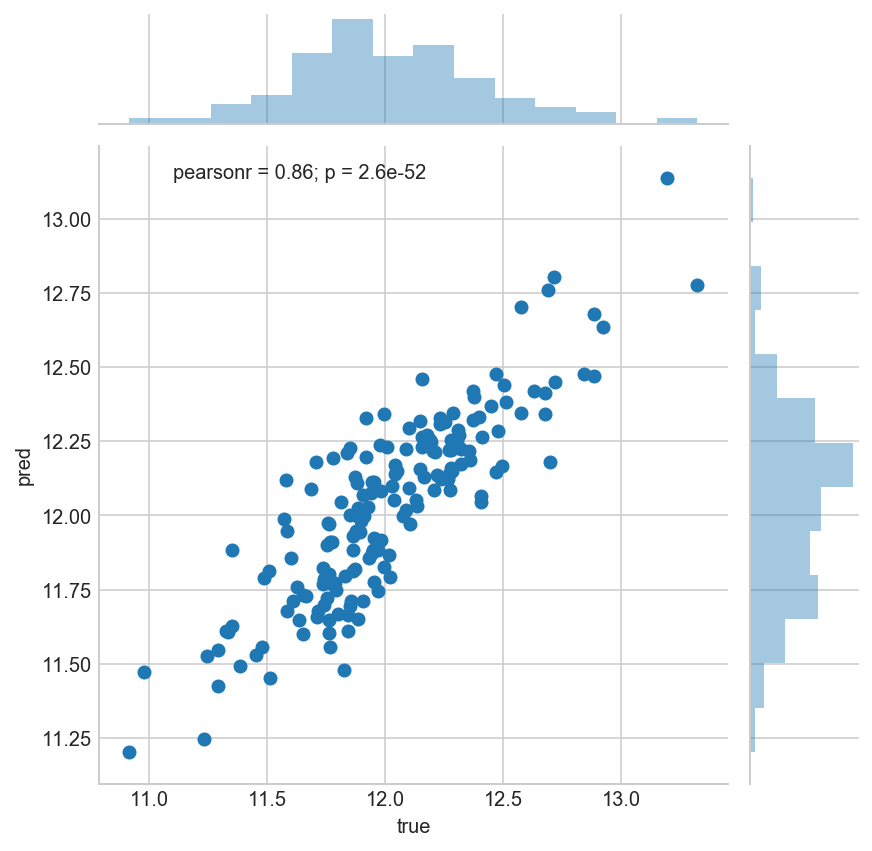

In [81]:
# Plot prediction against actual 
sns.jointplot(x='true', y='pred', data=data)

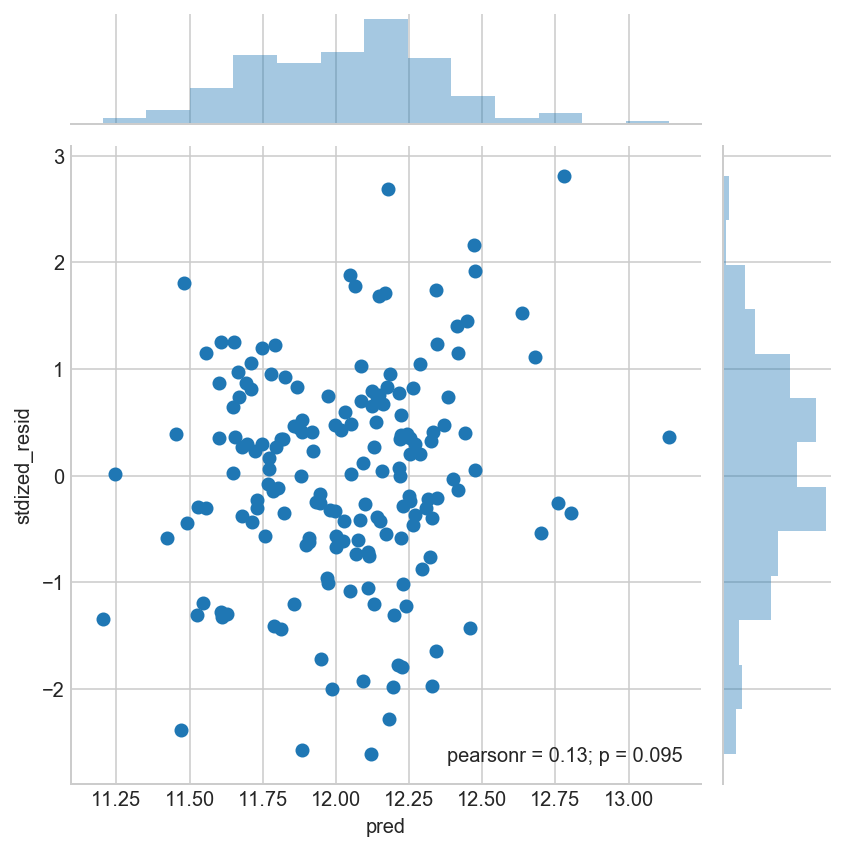

In [82]:
# plot residual against pred
sns.jointplot(x='pred', y='stdized_resid', data=data)

In [83]:
# No apparent relationship with predictions, normally distributed

In [84]:
# Predict for Training data to see if there is any outliers

In [85]:
# predict for training data using lasso
data_train = pd.DataFrame()
lasso.fit(Xs_train, y_train)
data_train['true'] = y_train
data_train['pred'] = lasso.predict(Xs_train)
data_train['resid'] = y_train - data_train.pred
data_train['stdized_resid'] = StandardScaler().fit_transform(data_train.resid.to_frame())

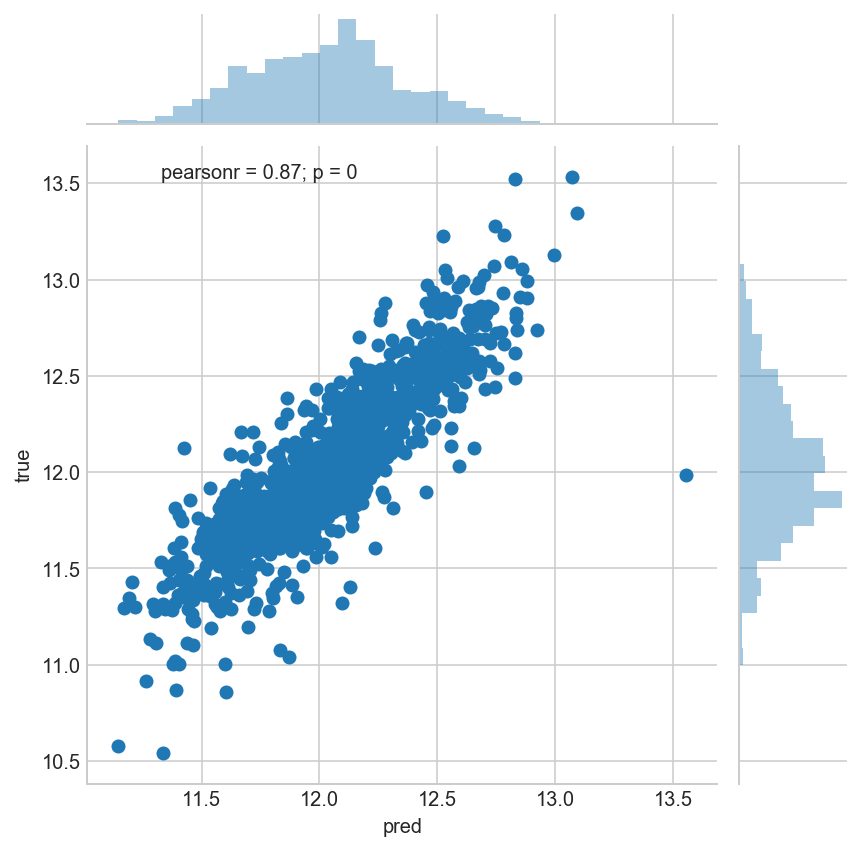

In [86]:
sns.jointplot(x='pred', y='true', data=data_train)

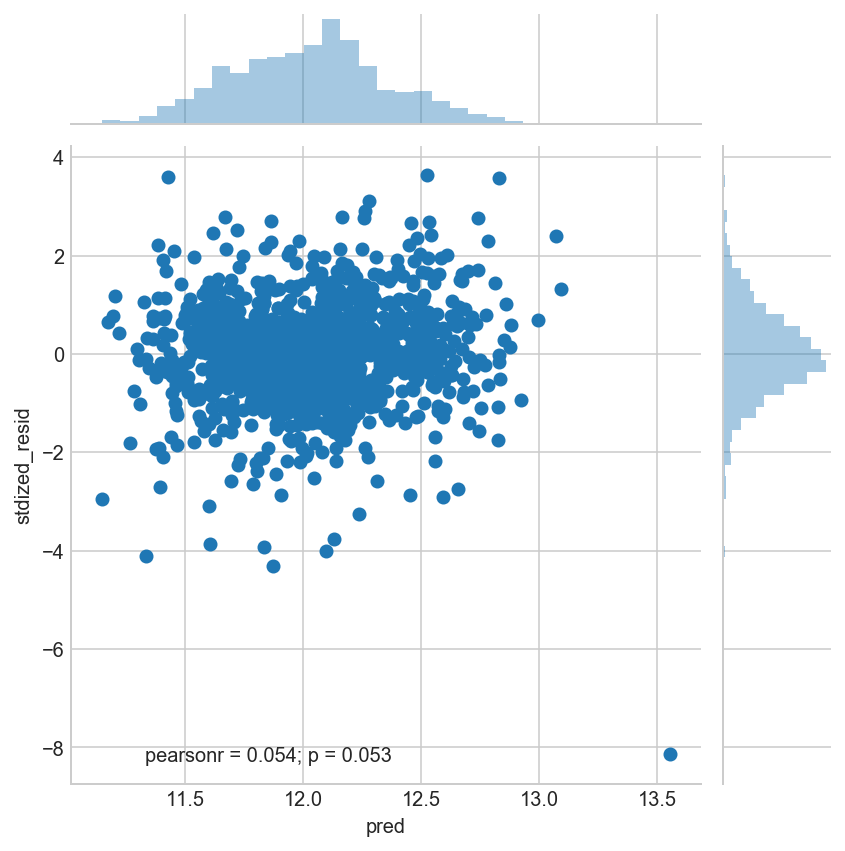

In [87]:
sns.jointplot(x='pred', y='stdized_resid', data=data_train)

In [88]:
# There is 1 outlier, we will find out which row is this

In [89]:
temp_df = pd.concat([pd.DataFrame(Xs_train, columns=X_train[indep_var_mask].columns), data_train], axis=1)
temp_df[temp_df.pred > 13.5]

,mszoning[T.RH],lotshape[T.IR2],lotshape[T.IR3],lotshape[T.Reg],lotconfig[T.CulDSac],lotconfig[T.FR2],lotconfig[T.FR3],lotconfig[T.Inside],neighborhood[T.Blueste],neighborhood[T.BrDale],...,masvnrarea,fireplaces,garagearea,totdeckporchsf,highqualfinsf_perc,age_remodel,true,pred,resid,stdized_resid
1137,-0.112598,-0.167803,11.260551,-1.293692,-0.260133,-0.182057,-0.056033,-1.63153,-0.03959,-0.108979,...,3.736006,3.719837,4.369195,2.07282,0.12044,-1.096176,11.982929,13.554715,-1.571786,-8.136569


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [90]:
# A:
# target variable now is residual
# predictors are non-fixed features
reno_features = [x for x in house.columns if x not in fixed_features]
len(reno_features)

21

In [91]:
reno_house = house[reno_features]

In [92]:
f = ' ~ ' + ' + '.join([col for col in reno_house.columns])
print(f)
reno_X = patsy.dmatrix(f, data=reno_house, return_type='dataframe')

 ~ overallqual + overallcond + roofstyle + exterqual + extercond + bsmtqual + bsmtcond + bsmtexposure + heatingqc + centralair + electrical + kitchenqual + functional + fireplacequ + garagefinish + garagequal + garagecond + saletype + salecondition + exterior + bsmtfintype


In [93]:
vif = pd.DataFrame()
vif["vif_factor"] = [variance_inflation_factor(reno_X.values, i) for i in range(reno_X.shape[1])]
vif["features"] = reno_X.columns

In [94]:
indep_var_mask = vif[vif['vif_factor']<=5].features.values.ravel()
reno_X = reno_X[indep_var_mask]

In [95]:
# Get y train & y test
reno_y_train = data_train.resid.values.ravel()
reno_y_test = data.resid.values.ravel()
print len(reno_y_train)
print len(reno_y_test)

1278
172


In [96]:
# Get X train & X test
reno_X_train = reno_X.loc[X_train.index]
reno_X_test = reno_X.loc[X_test.index]
print reno_X_train.shape
print reno_X_test.shape

(1278, 107)
(172, 107)


In [97]:
reno_Xs_train = StandardScaler().fit_transform(reno_X_train)
reno_Xs_test = StandardScaler().fit_transform(reno_X_test)

In [98]:
# Lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(reno_Xs_train, reno_y_train)

print optimal_lasso.alpha_

0.00695577064058


In [99]:
# Fit Lasso Model
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(reno_Xs_train, reno_y_train)
reno_lasso_pred = lasso.predict(reno_Xs_test) 
print'Lasso train Reno R2:', np.round(lasso.score(reno_Xs_train, reno_y_train), decimals=4)
print'Lasso Reno R2:', np.round(metrics.r2_score(reno_y_test, reno_lasso_pred), decimals=4)
print'Lasso Reno RMSE:', np.round(np.sqrt(metrics.mean_squared_error(reno_y_test, reno_lasso_pred)), decimals=4)

Lasso train Reno R2: 0.21
Lasso Reno R2: 0.1988
Lasso Reno RMSE: 0.1795


In [100]:
# Display the top 10 coefficients
reno_coefs = pd.DataFrame({'coef':lasso.coef_,
                            'mag':np.abs(lasso.coef_),
                            'pred':reno_X_train.columns})
reno_coefs.sort_values('mag', ascending=False, inplace=True)
reno_coefs.head(10)

,coef,mag,pred
101,0.063782,0.063782,overallqual
11,-0.015409,0.015409,functional[T.Maj2]
42,0.014855,0.014855,exterior[T.BrkFaceWd Sdng]
37,0.013498,0.013498,exterior[T.BrkFaceBrkFace]
96,0.009784,0.009784,bsmtfintype[T.7]
39,0.006282,0.006282,exterior[T.BrkFacePlywood]
102,0.005594,0.005594,overallcond
35,-0.005528,0.005528,exterior[T.BrkCommBrk Cmn]
67,-0.004977,0.004977,exterior[T.StuccoStucco]
16,-0.004704,0.004704,fireplacequ[T.2]


In [101]:
# Every 1 unit increase in overall quality increase the log sale price by 0.063358

# We can use the first model to buy property that are at least 0.2009 RMSE above / below our log predicted price
# Buying below our log predicted price are undervalued properties
# The second model can be used to identify renovatable parts that increase / decrease the log sale price of the house

# First model to guide purchase decision, second model to guide renovation decisions

# However result of the renovatable model is telling us that the existing renovatable features 
# is not very good at explaining the variance from fixed features
# Only about 20% of the variance can be explained by the renovatable features

In [104]:
reno_data = pd.DataFrame()
reno_data['true'] = reno_y_test
reno_data['pred'] = reno_lasso_pred
reno_data['resid'] = reno_y_test - reno_lasso_pred
reno_data['stdized_resid'] = StandardScaler().fit_transform(reno_data[['resid']])

In [105]:
# See whether prediction from model with all features different from just fixed features
# If different means we need to make some changes to our second model,
# otherwise it means that the renovatable features dont affect price much or 
# there are features that are missing from the dataset
# In the latter case, we should just use the first model to spot investment opportunities

In [106]:
f = 'saleprice ~ ' + ' + '.join([col for col in house.columns if col != 'saleprice'])
print(f)
all_y, all_X = patsy.dmatrices(f, data=house, return_type='dataframe')

saleprice ~ mszoning + lotfrontage + lotarea + lotshape + lotconfig + neighborhood + bldgtype + housestyle + overallqual + overallcond + roofstyle + masvnrtype + masvnrarea + exterqual + extercond + foundation + bsmtqual + bsmtcond + bsmtexposure + bsmtunfsf + totalbsmtsf + heatingqc + centralair + electrical + grlivarea + kitchenqual + functional + fireplaces + fireplacequ + garagetype + garagefinish + garagearea + garagequal + garagecond + paveddrive + mosold + yrsold + saletype + salecondition + condition + exterior + bsmtfinsf + highqualfinsf_perc + totdeckporchsf + age + age_remodel + garageage + bsmtfintype


In [107]:
vif = pd.DataFrame()
vif["vif_factor"] = [variance_inflation_factor(all_X.values, i) for i in range(all_X.shape[1])]
vif["features"] = all_X.columns

In [108]:
indep_var_mask = vif[vif['vif_factor']<=5].features.values.ravel()
all_X = all_X[indep_var_mask]

In [109]:
all_X_train = all_X.loc[X_train.index]
all_X_test = all_X.loc[X_test.index]
all_Xs_train = StandardScaler().fit_transform(all_X_train)
all_Xs_test = StandardScaler().fit_transform(all_X_test)

In [110]:
# Lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(all_Xs_train, y_train)

print optimal_lasso.alpha_

0.0057177200027


In [111]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(all_Xs_train, y_train)
all_lasso_pred = lasso.predict(all_Xs_test) 
print'ElasticNet train Reno R2:', np.round(lasso.score(all_Xs_train, y_train), decimals=4)
print'ElasticNet Reno R2:', np.round(metrics.r2_score(y_test, all_lasso_pred), decimals=4)
print'EasticNet Reno RMSE:', np.round(np.sqrt(metrics.mean_squared_error(y_test, all_lasso_pred)), decimals=4)

ElasticNet train Reno R2: 0.7884
ElasticNet Reno R2: 0.8099
EasticNet Reno RMSE: 0.1717


In [112]:
# The fit is better when you use all the features,
# It might be the case that renovatable features do have a slight impact on sale price
# Lets do t test to check whether both predictions are different to confirm

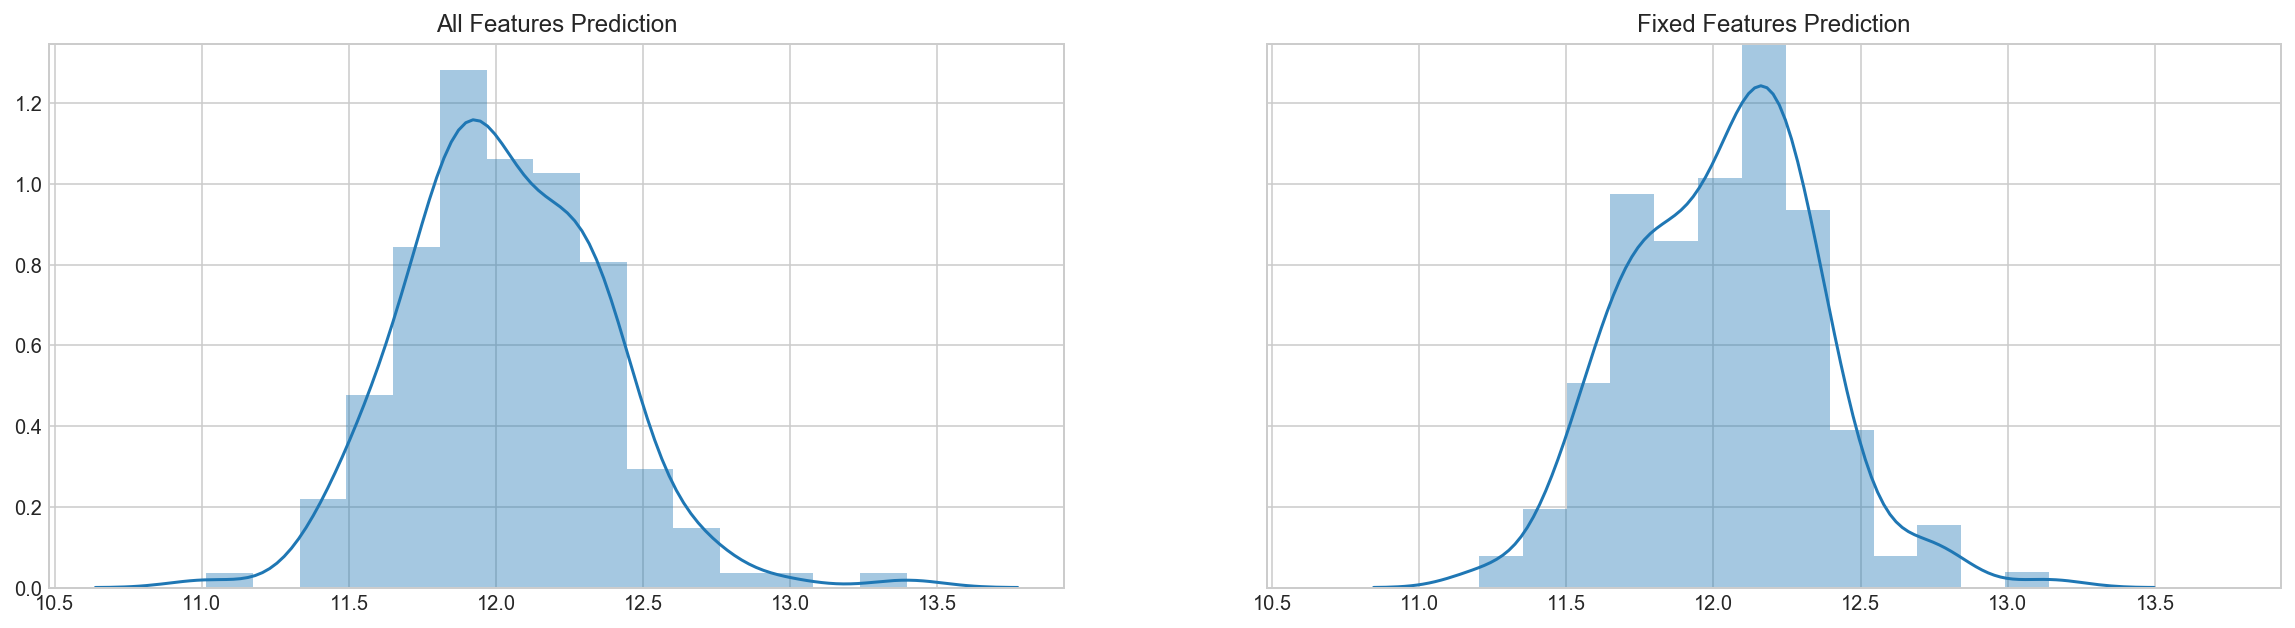

In [113]:
# See their variances
f, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=(20,5))
ax[0].set_title('All Features Prediction')
ax[1].set_title('Fixed Features Prediction')
sns.distplot(all_lasso_pred, ax=ax[0])
sns.distplot(lasso_pred, ax=ax[1])

In [114]:
# Check both means and medians
print 'Mean/Median for all features: ', np.mean(all_lasso_pred), np.median(all_lasso_pred)
print 'Mean/Median for fixed features: ', np.mean(lasso_pred), np.median(lasso_pred)

Mean/Median for all features:  12.0323556443 11.9988712549
Mean/Median for fixed features:  12.0323556443 12.0682954844


In [117]:
# Mean and Medians are very close for both distributions
# It is safe to assume that both are normally distributed
# Assumption for t test is that both variances must be the same
print 'Variance for all features:', np.std(all_lasso_pred)
print 'Variance for fixed features:', np.std(lasso_pred)

Variance for all features: 0.331308747031
Variance for fixed features: 0.314162117075


In [118]:
# Standard Deviation is very close, 
# Safe to do T test for related scores
ss.ttest_rel(all_lasso_pred, lasso_pred)

Ttest_relResult(statistic=-3.1771381579979887e-15, pvalue=0.99999999999999745)

In [119]:
# T test is above 0.05, we do not reject null hypothesis, average predictions between both are the same
# We can conclude that predicting sale prices using the fixed features model is no different from all features

# We can also conclude from this that the renovatable features have not much impact on sale price, which
# explains the low score from the renovatable features model.

# Therefore we should only use the Fixed model for spotting investment opportunities

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [151]:
# A:
house[house.salecondition == 'Abnorml'].shape[0] / float(house.shape[0])

0.06620689655172414

In [152]:
# Only 6% of the data are abnormal
# Get high recall on minority, high precision on majority

In [153]:
# Make new binary target, 1 == Abnorml & 0 == not
target = house.salecondition.map(lambda x: 1 if x == 'Abnorml' else 0)
print 'Base Accuracy', 1 - target.mean()

Base Accuracy 0.933793103448


In [154]:
f = ' ~ ' + ' + '.join([col for col in house.columns if col != 'salecondition'])
print(f)
logreg_X = patsy.dmatrix(f, data=house, return_type='dataframe')

 ~ mszoning + lotfrontage + lotarea + lotshape + lotconfig + neighborhood + bldgtype + housestyle + overallqual + overallcond + roofstyle + masvnrtype + masvnrarea + exterqual + extercond + foundation + bsmtqual + bsmtcond + bsmtexposure + bsmtunfsf + totalbsmtsf + heatingqc + centralair + electrical + grlivarea + kitchenqual + functional + fireplaces + fireplacequ + garagetype + garagefinish + garagearea + garagequal + garagecond + paveddrive + mosold + yrsold + saletype + saleprice + condition + exterior + bsmtfinsf + highqualfinsf_perc + totdeckporchsf + age + age_remodel + garageage + bsmtfintype


In [155]:
from imblearn.over_sampling import SMOTE

In [157]:
logreg_X_resampled, target_resampled = SMOTE(kind='regular').fit_sample(logreg_X, target)

In [160]:
logreg_X_resampled = pd.DataFrame(logreg_X_resampled,columns=logreg_X.columns)
target_resampled = pd.DataFrame(target_resampled)

In [161]:
# train / test set by year sold in 2010 or not
logreg_X_train = logreg_X_resampled[logreg_X_resampled['yrsold[T.2010]'] == 0]
logreg_X_test = logreg_X_resampled[logreg_X_resampled['yrsold[T.2010]'] == 1]
target_train = target_resampled.loc[logreg_X_train.index].values.ravel()
target_test = target_resampled.loc[logreg_X_test.index].values.ravel()
print logreg_X_train.shape
print logreg_X_test.shape
print target_train.shape
print target_test.shape

(2252, 244)
(188, 244)
(2252,)
(188,)


In [162]:
# Deal with Collinearity
vif = pd.DataFrame()
vif["vif_factor"] = [variance_inflation_factor(logreg_X.values, i) for i in range(logreg_X.shape[1])]
vif["features"] = logreg_X.columns

In [163]:
indep_var_mask = vif[vif['vif_factor']<=5].features.values.ravel()
logreg_X_train = logreg_X_train[indep_var_mask]
logreg_X_test = logreg_X_test[indep_var_mask]
print logreg_X_train.shape
print logreg_X_test.shape

(2252, 163)
(188, 163)


In [184]:
from sklearn.metrics import classification_report

In [165]:
logreg_Xs_train = StandardScaler().fit_transform(logreg_X_train)
logreg_Xs_test = StandardScaler().fit_transform(logreg_X_test)

In [166]:
# Plain Logistic Regression
lr = LogisticRegression()
lr.fit(logreg_Xs_train, target_train)
yhat_plain = lr.predict(logreg_Xs_test)

In [171]:
# Ridge Logistic Regression
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=200, cv=10)
lr_ridge.fit(logreg_Xs_train, target_train)

LogisticRegressionCV(Cs=200, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [173]:
yhat_ridge = lr_ridge.predict(logreg_Xs_test)

In [187]:
# Lasso Logistic Regression
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=100, cv=10)
lr_lasso.fit(logreg_Xs_train, target_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [189]:
yhat_lasso = lr_lasso.predict(logreg_Xs_test)

In [182]:
print classification_report(target_test, yhat_plain, labels=[1,0], target_names=['abnormal','not_abnormal'])

              precision    recall  f1-score   support

    abnormal       0.14      0.56      0.23        25
not_abnormal       0.88      0.49      0.63       163

 avg / total       0.78      0.50      0.58       188



In [183]:
print classification_report(target_test, yhat_ridge, labels=[1,0], target_names=['abnormal','not_abnormal'])

              precision    recall  f1-score   support

    abnormal       0.15      1.00      0.26        25
not_abnormal       1.00      0.14      0.25       163

 avg / total       0.89      0.26      0.25       188



In [190]:
print classification_report(target_test, yhat_lasso, labels=[1,0], target_names=['abnormal','not_abnormal'])

              precision    recall  f1-score   support

    abnormal       0.14      0.52      0.21        25
not_abnormal       0.87      0.49      0.63       163

 avg / total       0.77      0.49      0.57       188



In [208]:
# Ridge gets best precision and recall
# get best predictors of abnormal sales type

lr_ridge_coef = pd.DataFrame({'pred':logreg_X_test.columns,
                            'coef':lr_ridge.coef_.ravel(),
                            'mag':np.abs(lr_ridge.coef_.ravel()),
                             'log_odds':np.exp(lr_ridge.coef_.ravel())})

In [210]:
lr_ridge_coef.sort_values('mag', ascending=False, inplace=True)
lr_ridge_coef.head(10)

,coef,log_odds,mag,pred
124,22.677706,7.059962e+09,22.677706,exterior[T.VinylSdStucco]
114,11.493967,9.812202e+04,11.493967,exterior[T.StoneStone]
38,10.306192,2.991729e+04,10.306192,electrical[T.Mix]
72,9.022019,8.283483e+03,9.022019,saletype[T.Oth]
29,-6.406859,1.650200e-03,6.406859,foundation[T.Slab]
85,4.605291,1.000121e+02,4.605291,exterior[T.BrkCommBrk Cmn]
93,4.442015,8.494592e+01,4.442015,exterior[T.BrkFaceWd Shng]
113,2.628721,1.385603e+01,2.628721,exterior[T.StoneHdBoard]
52,-1.859826,1.556997e-01,1.859826,paveddrive[T.P]
21,-1.678109,1.867267e-01,1.678109,housestyle[T.1.5Unf]
